<a href="https://colab.research.google.com/github/Rukaya-lab/Smart-Reply-suggest/blob/main/Smart_Reply_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hdbscan

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import pandas as pd
import hdbscan

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.8.0


In [ ]:

with open('/content/input_texts.pickle', 'rb') as handle:
    input_texts = pickle.load(handle)

with open('/content/target_texts.pickle', 'rb') as handle:
    output_texts = pickle.load(handle)

with open('/content/target_dbscan_002.pickle', 'rb') as handle:
    dbscan002 = pickle.load(handle)

with open('/content/target_dbscan_006.pickle', 'rb') as handle:
    dbscan006 = pickle.load(handle)

with open('/content/target_hdbscan_auto.pickle', 'rb') as handle:
    hdbscan_auto = pickle.load(handle)

In [ ]:
print(len(input_texts))
print(len(dbscan006.labels_))

21921
21921


In [ ]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1

In [ ]:
total_words

13946

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
input_tokens = tokenizer.texts_to_sequences(input_texts)

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors = input_sequences

    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [ ]:
max_sequence_len

49

In [ ]:

labels = np.array(dbscan006.labels_, copy=True) #sceond
labels[labels == -1] = len(set(dbscan006.labels_)) - 1 #first change point
print(labels[:10])

[1271 1271 1271    0 1271 1271 1271 1271 1271    0]


In [ ]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(21921, 1272)

In [ ]:
with open('encoder_labelsdbscan006.pickle', 'wb') as handle:
    pickle.dump(encoder_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len
    model = tf.keras.Sequential()

    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 512, input_length=input_len))


    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.Dropout(0.2))

    # Add Output Layer
    model.add(tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 49, 512)           7140352   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1272)              652536    
                                                                 
Total params: 9,892,088
Trainable params: 9,892,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=25, verbose=1)

Epoch 1/25
686/686 [==============================] - 23s 34ms/step - loss: 2.5541 - accuracy: 0.6006
Epoch 2/25
686/686 [==============================] - 23s 34ms/step - loss: 2.3467 - accuracy: 0.6117
Epoch 3/25
686/686 [==============================] - 23s 34ms/step - loss: 2.0734 - accuracy: 0.6311
Epoch 4/25
686/686 [==============================] - 23s 34ms/step - loss: 1.7629 - accuracy: 0.6540
Epoch 5/25
686/686 [==============================] - 23s 34ms/step - loss: 1.4294 - accuracy: 0.6932
Epoch 6/25
686/686 [==============================] - 23s 34ms/step - loss: 1.0754 - accuracy: 0.7522
Epoch 7/25
686/686 [==============================] - 23s 34ms/step - loss: 0.7834 - accuracy: 0.8118
Epoch 8/25
686/686 [==============================] - 23s 34ms/step - loss: 0.5623 - accuracy: 0.8612
Epoch 9/25
686/686 [==============================] - 23s 34ms/step - loss: 0.4070 - accuracy: 0.8973
Epoch 10/25
686/686 [==============================] - 23s 34ms/step - loss: 0.328

In [ ]:
# Save model
model.save_model("sreply_006model.h5")
#model.save("sreply_lstmdbscan006.hdf5")

In [ ]:
from google.colab import files
files.download("sreply_lstmdbscan002.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

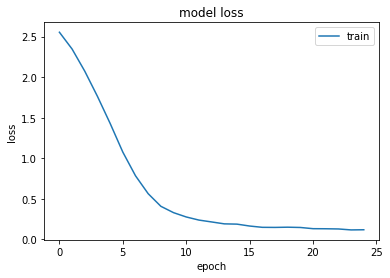

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
predict = model.predict(predictors, verbose=0)
predictions =np.argmax(predict,axis=1)
predictions

array([1271, 1271, 1271, ..., 1271, 1271, 1271])

In [ ]:
unique, counts = np.unique(predictions, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0  1982]
 [    1     2]
 [    2   460]
 ...
 [ 1269     2]
 [ 1270     2]
 [ 1271 13071]]


In [ ]:
model1= tf.keras.models.load_model("/content/sreply_lstmhdbscan (1).h5")#change to test

In [ ]:
def get_responses(seed_text, n):
    print("Input -", seed_text)
    print("----------------------")
    responses = list()
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
    with strategy.scope():
        predictions = model1.predict(token_list, verbose=10)

        predicted_indices = predictions.argsort()[0][::-1][:n]
        print(predicted_indices)


    for predicted_index in predicted_indices:
        score = 0
        if predicted_index == len(set(hdbscan_auto.labels_)) - 1: #another
            print("Predicting outside clusters")
            predicted_index = -1
        else:
            score = predictions[0][predicted_index]

        # randomly pick 1 index
        possible_response = np.where(hdbscan_auto.labels_==predicted_index)[0] #and another
        response_index = random.sample(possible_response.tolist(), 1)[0]
        #print(response_index)
        responses.append([output_texts[response_index].replace("\t", "").replace("\n", ""), score])


    for i, response in enumerate(responses):
        print("Response", (i + 1), "->", response[0], " -> Score :", response[1])

In [ ]:
get_responses("good bye", 6)

Input - good bye
----------------------
[472 475 450 330 362 213]
Predicting outside clusters
Response 1 -> bye  -> Score : 0.8691348
Response 2 -> hello yes i love reading do you enjoy it  -> Score : 0
Response 3 -> you too  -> Score : 0.026374219
Response 4 -> have a good one  -> Score : 0.01644659
Response 5 -> that  -> Score : 0.016087871
Response 6 -> same to you  -> Score : 0.010967484


In [ ]:
get_responses("bye", 10)

Input - bye
----------------------
[472 362 330 475 213 435 445 441 436 396]
Predicting outside clusters
Response 1 -> bye  -> Score : 0.79210925
Response 2 -> bye  -> Score : 0.058386285
Response 3 -> have a good one  -> Score : 0.040788736
Response 4 -> the birtish voice on siri  -> Score : 0
Response 5 -> same to you  -> Score : 0.0096162055
Response 6 -> have a good weekend  -> Score : 0.0078116287
Response 7 -> have a good evening  -> Score : 0.006580828
Response 8 -> good night  -> Score : 0.004865946
Response 9 -> see ya  -> Score : 0.004522089
Response 10 -> take care  -> Score : 0.0043005277


In [ ]:
get_responses("thank you", 6)

Input - thank you
----------------------
[   0  962 1271  980   58  999]
Predicting outside clusters
Response 1 -> bye  -> Score : 0.4944493
Response 2 -> i just call him the trumpster  -> Score : 0.25925457
Response 3 -> hip hop music as well  -> Score : 0
Response 4 -> have a good night  -> Score : 0.07295147
Response 5 -> have a great day  -> Score : 0.054827806
Response 6 -> have a good one  -> Score : 0.009643927


In [ ]:
get_responses("how is it going?", 6)

Input - how is it going?
----------------------
[1271    0  431  968    2  869]
Predicting outside clusters
Response 1 -> im doing good are you a fan of dogs  -> Score : 0
Response 2 -> yeah i know do you like soccer  -> Score : 0.03672769
Response 3 -> good how are you  -> Score : 0.021262256
Response 4 -> ohh ok  -> Score : 0.008917572
Response 5 -> same here  -> Score : 0.0050981697
Response 6 -> some stuff do you know what wikileaks is  -> Score : 0.0040161195


In [ ]:
get_responses("how are you?", 6)

Input - how are you?
----------------------
[1271    2    0  638  962  101]
Predicting outside clusters
Response 1 -> yes so sad do you like to travel  -> Score : 0
Response 2 -> most certainly  -> Score : 0.108636335
Response 3 -> thats pitiful  -> Score : 0.07628296
Response 4 -> im good how are you  -> Score : 0.016052432
Response 5 -> yes  -> Score : 0.009775669
Response 6 -> im great how are you  -> Score : 0.007960686


In [ ]:
get_responses("Will you do it?", 6)

Input - Will you do it?
----------------------
[1271    3    0  972    2    5]
Predicting outside clusters
Response 1 -> oh that is the circus gallop i believe right  -> Score : 0
Response 2 -> yes definitely and they also have a mytsa app  -> Score : 0.053073272
Response 3 -> you too  -> Score : 0.03921929
Response 4 -> i heard it was something like sixteen years worth  -> Score : 0.020353235
Response 5 -> take care  -> Score : 0.019421712
Response 6 -> i dont know but kudos to the women  -> Score : 0.011776306
